# Analysing Amazon Cutomer Reviews

##### Diana Martín Rodríguez

In this project, first we aims to predict whether the customer will return the product or not based on the customer review. Second, we identify whether there is any item on their stock that customer find disappointing. To do so, we use several techniques as sentiment analysis, who is part of the Natural Language Processing (NLP) techniques to understand if the customer reviews are positive or negative. Moreover, we explore how well machine learning algorithms perform when given the task to predict a returned product. Finally, we propose a dissapointed score to measure how much a product could be dissappointed based on the probabilities that the customer reviews and ratings are negatives and the probability that the product could be returned.

We will use the following data sets in this analysis:
- amazon_items.csv: contains the list of items with at least 1 minimal star review
- amazon_reviews.csv: contains reviews of the customer who bought any of those items in amazon_items.csv

#### Summary of Results

After analyzing the data, we conclude that :
- The sentiment analysis done allow us to identify the positive and negative customer's reviews.
- XGBoost is the best performing method when compared with the other algorithms used in this study.
- The quality of the results obtained when is used only the features extracted from the review text as input for making predictions is less than the others analysis when more features are used. However, notice that is completely possible to do it with quite good predictions (on holdout data: AUC: 0.93, Precision: 0.67, Recall: 0.87, F1 Score: 0.76)
- The dissapointed score measure allow us to identify a possible dissapointed product.

In [1]:
import re
import string
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, plot_confusion_matrix, confusion_matrix, roc_curve, auc, roc_auc_score
from xgboost import XGBClassifier
import nltk
from nltk.corpus import wordnet, stopwords
from nltk import pos_tag
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import tensorflow as tf
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.utils import class_weight
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
import demoji
from wordcloud import WordCloud
# for reproducibility
random.seed(2)
np.random.seed(3)  
tf.random.set_seed(4) 

In [2]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet') 
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('words')
demoji.download_codes()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/guillermo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/guillermo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/guillermo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/guillermo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/guillermo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/guillermo/nltk_data...
[nltk_data]   Package words is already up-to-date!


... OK (Got response in 0.66 seconds)
Writing emoji data to /home/guillermo/.demoji/codes.json ...
... OK


## Datasets Description

We'll load the datasets and we will briefly present the description of the dataset.

In [3]:
#load datasets
amazon_reviews = pd.read_csv('amazon_reviews.csv', delimiter=';', encoding='utf-8')
amazon_products = pd.read_csv('amazon_items.csv', delimiter=',', encoding='utf-8')

In [4]:
amazon_reviews.info()
amazon_reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67986 entries, 0 to 67985
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   asin           67986 non-null  object 
 1   name           67984 non-null  object 
 2   rating         67986 non-null  int64  
 3   date           67986 non-null  object 
 4   verified       67986 non-null  bool   
 5   title          67972 non-null  object 
 6   body           67965 non-null  object 
 7   helpfulVotes   27215 non-null  float64
 8   returnProduct  67450 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(5)
memory usage: 4.2+ MB


,asin,name,rating,date,verified,title,body,helpfulVotes,returnProduct
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0,1.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0,0.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0,0.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0,0.0


This information shows how amazon_reviews dataset contains 9 columns with 67986 rows, where most of them are strings and floats. Some columns have a few missing values, except helpfulVotes that have more than ~50% null values.

In [5]:
amazon_products.info()
amazon_products.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   asin           720 non-null    object 
 1   brand          716 non-null    object 
 2   title          720 non-null    object 
 3   url            720 non-null    object 
 4   image          720 non-null    object 
 5   rating         720 non-null    float64
 6   reviewUrl      720 non-null    object 
 7   totalReviews   720 non-null    int64  
 8   price          720 non-null    float64
 9   originalPrice  720 non-null    float64
dtypes: float64(3), int64(1), object(6)
memory usage: 56.4+ KB


,asin,brand,title,url,image,rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.00,0.0
1,B0009N5L7K,Motorola,Motorola I265 phone,https://www.amazon.com/Motorola-i265-I265-phon...,https://m.media-amazon.com/images/I/419WBAVDAR...,3.0,https://www.amazon.com/product-reviews/B0009N5L7K,7,49.95,0.0
2,B000SKTZ0S,Motorola,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,https://www.amazon.com/MOTOROLA-C168i-CINGULAR...,https://m.media-amazon.com/images/I/71b+q3ydkI...,2.7,https://www.amazon.com/product-reviews/B000SKTZ0S,22,99.99,0.0
3,B001AO4OUC,Motorola,Motorola i335 Cell Phone Boost Mobile,https://www.amazon.com/Motorola-i335-Phone-Boo...,https://m.media-amazon.com/images/I/710UO8gdT+...,3.3,https://www.amazon.com/product-reviews/B001AO4OUC,21,0.00,0.0
4,B001DCJAJG,Motorola,Motorola V365 no contract cellular phone AT&T,https://www.amazon.com/Motorola-V365-contract-...,https://m.media-amazon.com/images/I/61LYNCVrrK...,3.1,https://www.amazon.com/product-reviews/B001DCJAJG,12,149.99,0.0


This information shows how amazon_products dataset contains 10 columns with 720 products descriptions, where most of them are also strings and float and the brand feauture is the only column that present only four missing values. 

## Data Exploration

In this section, we investigate the characteristics of the data. We analyze the statistical information of the dataset and missing values in the data.


In [6]:
amazon_reviews['returnProduct'] = amazon_reviews['returnProduct'].astype('object')
amazon_reviews.describe(include = 'all')

,asin,name,rating,date,verified,title,body,helpfulVotes,returnProduct
count,67986,67984,67986.000000,67986,67986,67972,67965,27215.000000,67450.0
unique,720,47321,NaN,2983,2,41489,59811,NaN,2.0
top,B00F2SKPIM,Amazon Customer,NaN,"December 11, 2019",True,Five Stars,Good,NaN,0.0
freq,981,6507,NaN,234,61225,6043,303,NaN,50266.0
mean,NaN,NaN,3.807916,NaN,NaN,NaN,NaN,8.229690,NaN
std,NaN,NaN,1.582906,NaN,NaN,NaN,NaN,31.954877,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN
25%,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,1.000000,NaN
50%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,2.000000,NaN
75%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,5.000000,NaN


In [7]:
amazon_products.describe(include = 'all')

,asin,brand,title,url,image,rating,reviewUrl,totalReviews,price,originalPrice
count,720,716,720,720,720,720.000000,720,720.000000,720.000000,720.000000
unique,720,10,718,720,679,NaN,720,NaN,NaN,NaN
top,B07P2H2GZ8,Samsung,"Apple iPhone 6S, 64GB, Rose Gold - For AT&T / ...",https://www.amazon.com/Apple-iPhone-64GB-Fully...,https://m.media-amazon.com/images/I/81yZOQEC+N...,NaN,https://www.amazon.com/product-reviews/B07QCXPP71,NaN,NaN,NaN
freq,1,346,2,1,3,NaN,1,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,3.713750,NaN,105.679167,234.948931,63.690778
std,NaN,NaN,NaN,NaN,NaN,0.716014,NaN,167.601101,200.008441,172.405370
min,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,3.300000,NaN,7.000000,97.512500,0.000000
50%,NaN,NaN,NaN,NaN,NaN,3.800000,NaN,32.000000,188.975000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,4.100000,NaN,122.250000,336.725000,0.000000


These results show how most of non numeric features present many distinct values, except the brand column in amazon_products with 10 unique values and the verified and returnProduct with two unique values. We will explore the distribution of these columns in the next subsection.

The numeric columns need more investigation to analyze the values distribution, however, we can see how the originalPrice column from amazon_products dataset presents a zero value in almost all the dataset. We will plot the values of these columns with a boxplot to identify any values that look wrong.

The returnProduct column presents two values that represent if the product was return (1) or not (0), where the most frequent is zero. Notice that both values are imbalanced, therefore, we will be working with an imbalanced dataset.

A small number of missing values for most of the columns are presented. However, we will present a further analyzes of how to handle them.

### Exploring Categorical Columns  <a class="anchor" id="explore-categorical"></a>

Now, we will generate plot bars for the following categorical columns, calling the *value_counts* method to get a count of unique values for them.

- From amazon_reviews the features: verified, returnProduct
- From amazon_products the feature: brand 

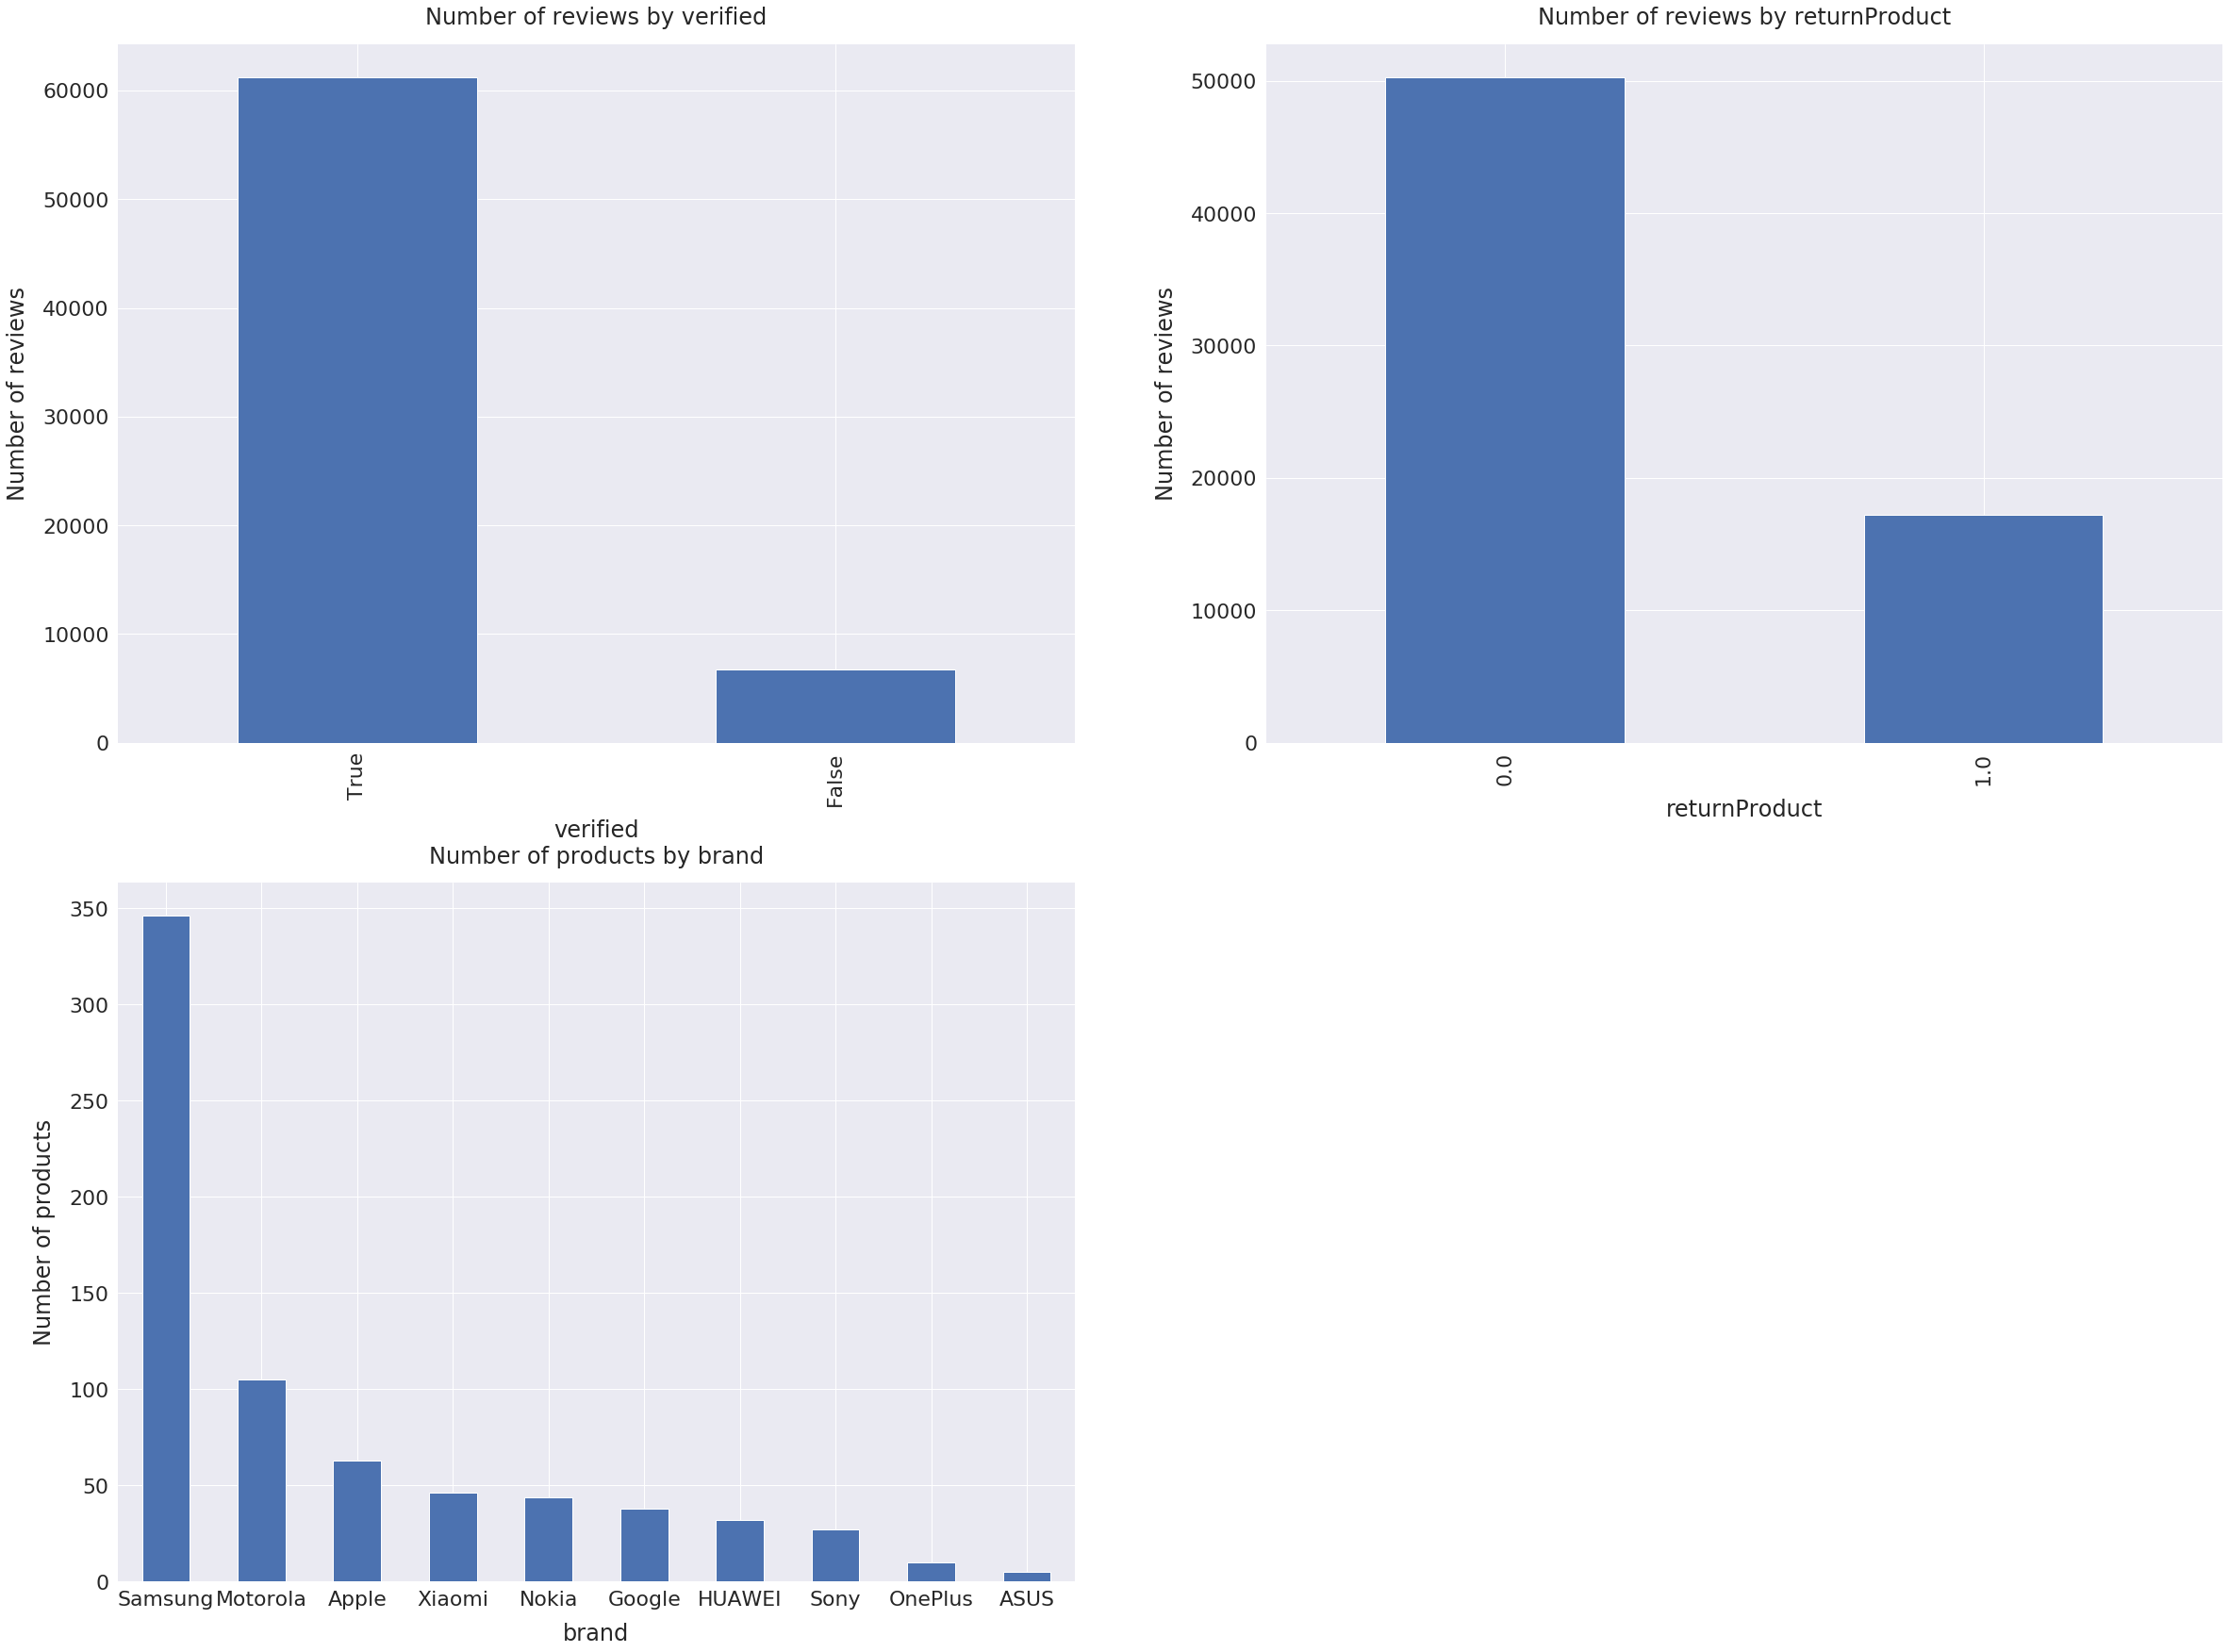

In [8]:
# plotting the number of each different value from the categorical columns using bar charts
sns.set(font_scale=2)
fig = plt.figure(figsize=(40, 30))
categ_cols = ["verified", "returnProduct", "brand"]
for i, col_name in zip(range(len(categ_cols)), categ_cols):
    ax = fig.add_subplot(2,2,i+1)
    if i == 2:
        ax = amazon_products[col_name].value_counts().plot(kind='bar', rot=0)
        ax.set_ylabel("Number of products", labelpad=14)
        ax.set_title("Number of products by " + col_name, y=1.02);    
    else:
        ax = amazon_reviews[col_name].value_counts().plot(kind='bar')
        ax.set_ylabel("Number of reviews", labelpad=14)
        ax.set_title("Number of reviews by " + col_name, y=1.02);
    for key,spine in ax.spines.items():
         spine.set_visible(False)
    ax.set_xlabel(col_name, labelpad=14)
   

These figures show how more than ~90% of the customers are verified and most of the products present Samsung brand, follows by Motorola.

Notice, that our dataset is imbalanced because around ~25% of the products are returned. This information will be very useful for the modelling part.

### Exploring Numeric Columns 

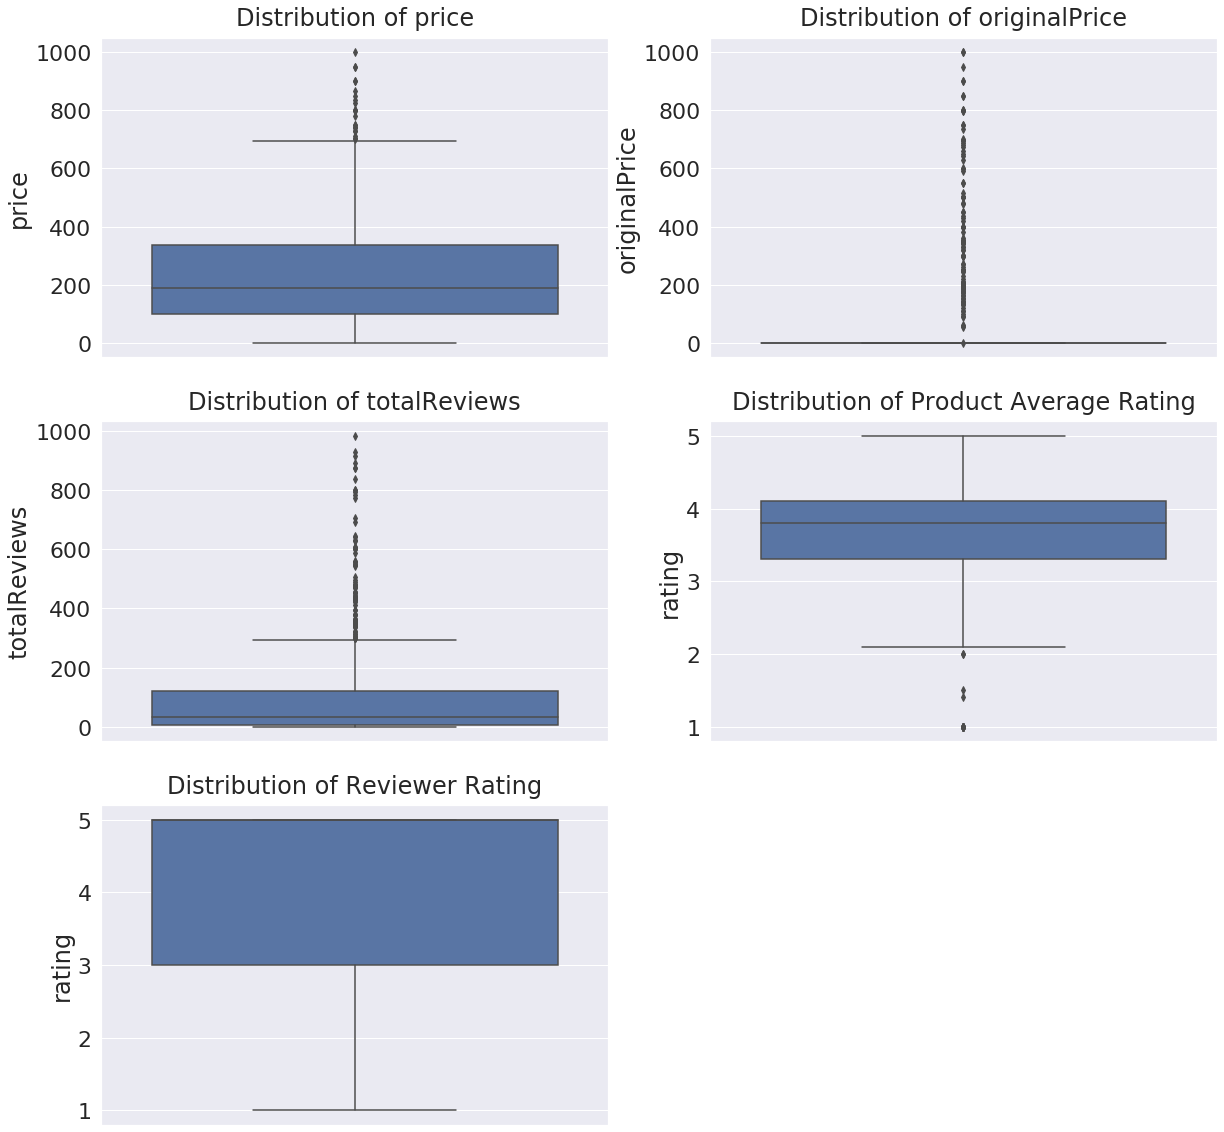

In [9]:
# plotting the distribution of the numeric columns using boxplot charts
fig = plt.figure(figsize=(20,20))
numeric_columns = ["price", "originalPrice", "totalReviews", "rating"]
#create two charts for each rating column in both datasets
for i, col_name in zip(range(len(numeric_columns)), numeric_columns):
    ax = fig.add_subplot(3,2,i+1)
    ax = sns.boxplot(y=amazon_products[col_name])
    ax.set_title("Distribution of " + col_name, y=1.02)
    if i == 3:
        ax.set_title("Distribution of Product Average Rating", y=1.02)
        ax = fig.add_subplot(3,2,i+2)
        ax = sns.boxplot(y=amazon_reviews[col_name])
        ax.set_title("Distribution of Reviewer Rating", y=1.02)  
   

Let's analyze the number of outliers. We will count how many outliers present the numeric column from amazon_product dataset, using the IQR score, where anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier.

In [10]:
data_col = amazon_products[numeric_columns]
Q1 = data_col.quantile(0.25)
Q3 = data_col.quantile(0.75)
IQR = Q3 - Q1

# get a dataframe where True represent that the value is an outlier.
outlier_df = ((data_col < (Q1 - 1.5 * IQR)) |(data_col > (Q3 + 1.5 * IQR)))

print("Number of outliers for numeric colums from amazon_products")
outlier_df.apply(pd.Series.value_counts)

Number of outliers for numeric colums from amazon_products


,price,originalPrice,totalReviews,rating
False,698,600,635,700
True,22,120,85,20


By the analysis of the figures and table presented, we can highlight the following facts:

- Most of the phones are selled with values between ~100 and almost 400. However, 22 of them are selled with values higher than 700. 
- Most the products have total reviews more than 10 and less than 150. 
- The originalPrice feature presents almost all the values with zero, where only 120 are different than it. Then, we will remove this column.
- Most of the customers give rating values of the products between 3 and 5. Then, on average the rating values of the products are around 3 and 4 values, where 20 products present values less than 2.

### Missing Values <a class="anchor" id="missing-values"></a>

In this section, we will check for missing values in the dataset and analyse how to handle them.

In [11]:
missing_values_products = amazon_products.isnull().sum()
percent_missing_products = amazon_products.isnull().sum() * 100 / len(amazon_products)
missing_values_products_df = pd.concat([missing_values_products, percent_missing_products], axis = 1).rename(columns = {0:'Missing Values', 1:'Percentage'})
print('Missing values amazon_products dataset')
missing_values_products_df

Missing values amazon_products dataset


,Missing Values,Percentage
asin,0,0.000000
brand,4,0.555556
title,0,0.000000
url,0,0.000000
image,0,0.000000
rating,0,0.000000
reviewUrl,0,0.000000
totalReviews,0,0.000000
price,0,0.000000
originalPrice,0,0.000000


In [12]:
missing_values_reviews = amazon_reviews.isnull().sum()
percent_missing_reviews = amazon_reviews.isnull().sum() * 100 / len(amazon_reviews)
missing_values_reviews_df = pd.concat([missing_values_reviews, percent_missing_reviews], axis = 1).rename(columns = {0:'Missing Values', 1:'Percentage'})
print('Missing values amazon_reviews dataset')
missing_values_reviews_df

Missing values amazon_reviews dataset


,Missing Values,Percentage
asin,0,0.000000
name,2,0.002942
rating,0,0.000000
date,0,0.000000
verified,0,0.000000
title,14,0.020592
body,21,0.030889
helpfulVotes,40771,59.969700
returnProduct,536,0.788398


We can see above that amazon_product dataset has almost no missing values.

The amazon_reviews dataset present few missing values in the name, title, body and returnProduct column and high number of them in helpfulVotes.

We can learn more about where these missing values are located by visualizing them with a heatmap, a graphical representation of our data in which values are represented as colors. We'll use the seaborn library to create the heatmap. Notice that, missing values are highlighted in light gray and all other values in black.

Text(0.5, 1, 'Heatmap that represents missing values from amazon_reviews dataset (highlighted in light gray)')

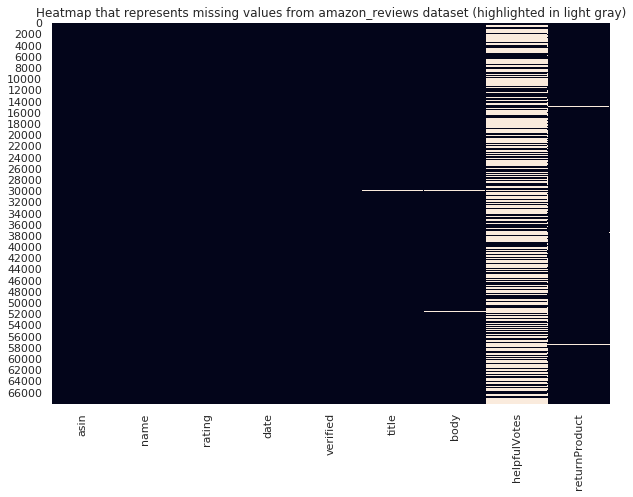

In [13]:
sns.set(font_scale=1.0)
fig = plt.figure(figsize=(10,7))
ax = sns.heatmap(amazon_reviews.isnull(), cbar=False)
ax.set_title('Heatmap that represents missing values from amazon_reviews dataset (highlighted in light gray)')

We can make the following observations:
- The helpfulVotes feature has almost 60% of missing values. Then, we will remove it.
- There are few rows with missing values in the rest of the columns.

## Preprocessing the Data <a class="anchor" id="preprocessing-data"></a>

In this section, we will first preprocess the *categorical and numeric features* by taking into consideration, what is mentioned in the previous section. Second, we will preprocess the *text fields* (title and body from amazon_reviews).

### Preprocess of categorical and numeric features

Delete the following columns:
- Delete the columns title, url, image from amazon_product and name and date from amazon_reviews since present a lot of unique values and some of them are not interesting for our goal.
- Delete the column  helpfulVotes from amazon_reviews with almost the 60% of the values missing.
- Delete verified that present 90% of true values from amazon_reviews
- Delete originalPrice from amazon_product with almost all the values equals to 0


In [14]:
# delete name, date, helpfulVotes, verified columns from amazon_reviews
amazon_reviews = amazon_reviews.drop(['name', 'date', 'helpfulVotes', 'verified'], axis=1)

In [15]:
# delete title, url, image, originalPrice columns from amazon_products
amazon_products = amazon_products.drop(['title', 'url', 'reviewUrl', 'image', 'originalPrice'], axis=1)

- Remove rows with missing values in the rest of the columns from amazon_reviews

In [16]:
#drop the rows where at least one element is missing in amazon_reviews
print("Number of initial rows in the amazon_reviews dataset: {}".format(amazon_reviews.shape[0]))
print("Number of rows with missing values that will be removed : {}".format((amazon_reviews.shape[0] - amazon_reviews.dropna().shape[0])))
amazon_reviews = amazon_reviews.dropna()

Number of initial rows in the amazon_reviews dataset: 67986
Number of rows with missing values that will be removed : 566


- Rescale the data using *minmax_scale* from *sklearn.preprocessing*, since we can see a difference between the range of each numeric column. In order to make sure these values are equally weighted within the classification model, we'll need to rescale the data.

In [17]:
# rescale data using minmax_scale from sklearn.preprocessing
for col in ['price', 'totalReviews', 'rating']:
    amazon_products[col] = minmax_scale(amazon_products[col])
    if col == 'rating':
        amazon_reviews[col] = minmax_scale(amazon_reviews[col])

-  Create dummy columns for each unique value for the brand column since most machine learning algorithms can't understand text labels, so we have to convert our values into numbers.
To do so, we will apply OneHotEncoder from sklearn library

In [18]:
# fill missing values from brand file to be able to use OneHotEncoder
amazon_products['brand'].fillna('None', inplace=True) 

In [19]:
# apply one-hot encoder
enc = OneHotEncoder()
brand = amazon_products['brand'].to_numpy().reshape(-1, 1)
one_hot_brand = pd.DataFrame(enc.fit_transform(brand).toarray(), columns=['brandASUS', 'brandApple', 'brandGoogle', 'brandHUAWEI', 'brandMotorola','brandNokia', 'brandNone', 'brandOnePlus', 'brandSamsung', 'brandSony', 'brandXiaomi'])
# add one-hot encoded columns to amazon_products
amazon_products = pd.concat([amazon_products, one_hot_brand], axis=1)

In [20]:
# convert returnProduct's values to int values
amazon_reviews['returnProduct'] = amazon_reviews['returnProduct'].astype('int')

In [21]:
amazon_reviews['returnProduct'].value_counts()

0    50243
1    17177
Name: returnProduct, dtype: int64

### Clean text data from reviews customers

First, we combine both 'title' and 'body' columns and make one single column from 'amazon_reviews' dataset.

In [22]:
def combined_title_body(row):
    return row['title'] + ' '+ row['body']
amazon_reviews['reviewComplete'] = amazon_reviews.apply(combined_title_body, axis=1)
# delete title and body since they will not used
amazon_reviews = amazon_reviews.drop(['title', 'body'], axis=1)
amazon_reviews.head()

,asin,rating,returnProduct,reviewComplete
0,B0000SX2UC,0.50,1,"Def not best, but not worst I had the Samsung ..."
1,B0000SX2UC,0.00,1,Text Messaging Doesn't Work Due to a software ...
2,B0000SX2UC,1.00,0,"Love This Phone This is a great, reliable phon..."
3,B0000SX2UC,0.50,0,"Love the Phone, BUT...! I love the phone and a..."
4,B0000SX2UC,0.75,0,"Great phone service and options, lousy case! T..."


Before clean the text, we will make the following actions:

- Remove the following stop words from all the stop words since they could change the meaning of the review (positive or negative).

In [23]:
# prepare the list of stop words to remove in the reviews
all_stop_words = stopwords.words('english')
remove_stop_words = ['but', 'no', 'nor', 'not', 'very']
stop_words = [stop_word for stop_word in all_stop_words if stop_word not in remove_stop_words]

- In order to remove words that are unusual in english lenguage, we will get the set english vocabulary. 

In [24]:
# get the set english vocabulary to remove the unusual words in english
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

- Get the name of the product's brand to keep them in the review text, otherwise they would be removed once the unusual words from english were removed.

In [25]:
brands_list = amazon_products['brand'].value_counts().index.tolist()
brands_list = [brand.lower() for brand in brands_list]

In [26]:
#remove brand feature, since the one hot encode was already done on it
amazon_products = amazon_products.drop(['brand'], axis=1)

The clean_text method do the following operations:
- lower the text
- tokenize the text (split the text into words) and remove the punctuation
- remove useless words that contain numbers
- remove useless stop words like 'the', 'a','this', etc.
- remove emojis characters
- Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database
- lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)
- remove words that are unusual in english lenguage, keeping the brand's name of the products

In [27]:
# return the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# clean the review text
def clean_text(text):
    # lower text
    text = text.lower()
    #remove tags
    text = re.sub("","",text)
    # remove special characters and digits
    text = re.sub("(\\d|\\W)+"," ",text)
    # remove emojis
    text = demoji.replace(text, "")
    # tokenize text and remove puncutation 
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    text = [word for word in text if word not in stop_words]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text in order to normalize words
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # remove words that are unusual or mis-spelt in english language, keeping the names of the brand's products
    text = [word for word in text if word in english_vocab or word in brands_list]
    # join all
    text = " ".join(text)
    return(text)

In [28]:
# clean text data
amazon_reviews["reviewClean"] = amazon_reviews["reviewComplete"].apply(lambda x: clean_text(x))

### Feature engineering from text data
In this section, we will create new features extracted from the text data.
#### Adding simple metrics for every text
- number of characters in the text 
- number of words in the text

In [29]:
# add number of characters column
amazon_reviews["nChars"] = amazon_reviews["reviewClean"].apply(lambda x: len(x))

# add number of words column
amazon_reviews["nWords"] = amazon_reviews["reviewClean"].apply(lambda x: len(x.split()))

Remove the rows with empty values in reviewClean field using the nWords column created

In [30]:
print("Number of rows with  with empty values in reviewClean field: {}".format((amazon_reviews[amazon_reviews["nWords"] == 0].shape[0])))

# remove the rows with empty values in reviewClean field, will be the ones with nWords = 0
amazon_reviews = amazon_reviews[amazon_reviews['nWords'] > 0]

Number of rows with  with empty values in reviewClean field: 387


#### Adding sentiment analysis features
We first start by adding sentiment analysis features because we can guess that customers reviews are highly linked to the decision about return or not a product. We use Vader, which is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into account the context of the sentences to determine the sentiment scores. For each text, Vader returns 4 values:
- a neutrality score
- a positivity score
- a negativity score
- an overall score that summarizes the previous scores

We will integrate those 4 values as features in our dataset.

In [31]:
# add sentiment anaylsis columns
sid = SentimentIntensityAnalyzer()
amazon_reviews['sentiments'] = amazon_reviews['reviewClean'].apply(lambda x: sid.polarity_scores(x))
amazon_reviews = pd.concat([amazon_reviews.drop(['sentiments'], axis=1), amazon_reviews['sentiments'].apply(pd.Series)], axis=1).rename(columns = {'neg':'negativeScore', 'pos':'positiveScore', 'neu':'neutralScore', 'compound':'totalScore' })

In [32]:
amazon_reviews.head(3)

,asin,rating,returnProduct,reviewComplete,reviewClean,nChars,nWords,negativeScore,neutralScore,positiveScore,totalScore
0,B0000SX2UC,0.5,1,"Def not best, but not worst I had the Samsung ...",not best but not bad samsung awhile absolute r...,958,160,0.193,0.550,0.258,0.9383
1,B0000SX2UC,0.0,1,Text Messaging Doesn't Work Due to a software ...,text work due issue nokia sprint phone text me...,416,65,0.035,0.756,0.209,0.9062
2,B0000SX2UC,1.0,0,"Love This Phone This is a great, reliable phon...",love phone great reliable phone also purchase ...,420,66,0.110,0.684,0.206,0.7057


#### Word Embeddings (Text Vectorization)

The machine learning and deep learning techniques require the string/text needs to be converted into a set of real numbers (a vector), that is called Word Embeddings, a methodoly in NLP. The idea is to map words or phrases from vocabulary to a corresponding vector of real numbers which used to find word predictions, word similarities/semantics.

Word embeddings coming from pre-trained methods such as: Word2Vec from Google, Fasttext from Facebook and Glove from Standford. We will use Word2Vec, one of the most popular embedding architecture implemented in the Gensim Python library.

The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). The idea is that similar words will have similar representation vectors.

In [33]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(amazon_reviews["reviewClean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = amazon_reviews["reviewClean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
amazon_reviews = pd.concat([amazon_reviews, doc2vec_df], axis=1)

In [34]:
amazon_reviews.head()

,asin,rating,returnProduct,reviewComplete,reviewClean,nChars,nWords,negativeScore,neutralScore,positiveScore,totalScore,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,B0000SX2UC,0.50,1,"Def not best, but not worst I had the Samsung ...",not best but not bad samsung awhile absolute r...,958,160,0.193,0.550,0.258,0.9383,0.413259,-0.442111,0.169013,-0.327757,-1.232956
1,B0000SX2UC,0.00,1,Text Messaging Doesn't Work Due to a software ...,text work due issue nokia sprint phone text me...,416,65,0.035,0.756,0.209,0.9062,1.143064,0.107827,0.392138,0.460260,-0.199072
2,B0000SX2UC,1.00,0,"Love This Phone This is a great, reliable phon...",love phone great reliable phone also purchase ...,420,66,0.110,0.684,0.206,0.7057,0.162627,-0.284278,0.437954,-0.366150,-0.975057
3,B0000SX2UC,0.50,0,"Love the Phone, BUT...! I love the phone and a...",love phone but love phone really need one but ...,263,46,0.000,0.692,0.308,0.9668,0.176056,0.606571,0.436572,-0.012937,0.126631
4,B0000SX2UC,0.75,0,"Great phone service and options, lousy case! T...",great phone service option lousy case phone gr...,327,61,0.144,0.624,0.232,0.7223,0.192407,0.295333,0.189697,-0.346994,-0.312968


#### Adding TF-IDF (Term Frequency — Inverse Document Frequency)

We add TF-IDF columns for every word that appear in at least a number of different texts to filter some of them and reduce the size of the final output. We will use a number of 25% of the total texts. This number could be change in order to add more TF-IDF feature words.

The TF-IDF metric solves this problem:

   - TF computes the classic number of times the word appears in the text
   - IDF computes the relative importance of this word which depends on how many texts the word can be found

In [35]:
# add tf-idfs columns
number_perc_reviews = int(amazon_reviews.shape[0]*0.25)
tfidf = TfidfVectorizer(min_df = number_perc_reviews)
tfidf_result = tfidf.fit_transform(amazon_reviews["reviewClean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = amazon_reviews.index
amazon_reviews = pd.concat([amazon_reviews, tfidf_df], axis=1)

In [36]:
amazon_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67033 entries, 0 to 67985
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   asin              67033 non-null  object 
 1   rating            67033 non-null  float64
 2   returnProduct     67033 non-null  int64  
 3   reviewComplete    67033 non-null  object 
 4   reviewClean       67033 non-null  object 
 5   nChars            67033 non-null  int64  
 6   nWords            67033 non-null  int64  
 7   negativeScore     67033 non-null  float64
 8   neutralScore      67033 non-null  float64
 9   positiveScore     67033 non-null  float64
 10  totalScore        67033 non-null  float64
 11  doc2vec_vector_0  67033 non-null  float32
 12  doc2vec_vector_1  67033 non-null  float32
 13  doc2vec_vector_2  67033 non-null  float32
 14  doc2vec_vector_3  67033 non-null  float32
 15  doc2vec_vector_4  67033 non-null  float32
 16  word_but          67033 non-null  float6

## Exploratory data analysis from reviews

In this section, we will explore a little bit the data information extracted from text reviews.

Create and plot wordcloud for positive and negative reviews to see what kind of words apear in our reviews.

In [37]:
# wordcloud function
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

Generating a WordCloud of positive reviews.

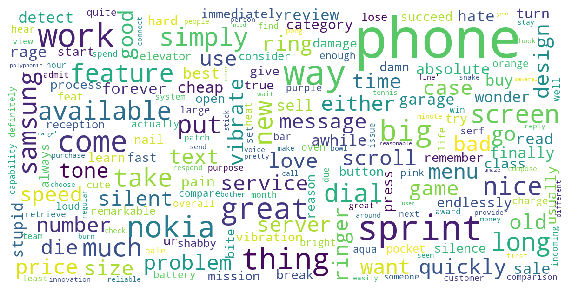

In [38]:
# print wordcloud of the most positive reviews
amazon_pos_reviews = amazon_reviews[amazon_reviews["totalScore"] >= 0.7]
show_wordcloud(amazon_pos_reviews["reviewClean"].values)

Most of the words are related to the phones products: phone, tone, ring, message, vibrate. Some words are more related to the customer experience with the product: work, great, nice, available, expensive. Notice how the samsung and nokia brands are shown, then could be many positive reviews related with these brands.

Generating a WordCloud of negative reviews.

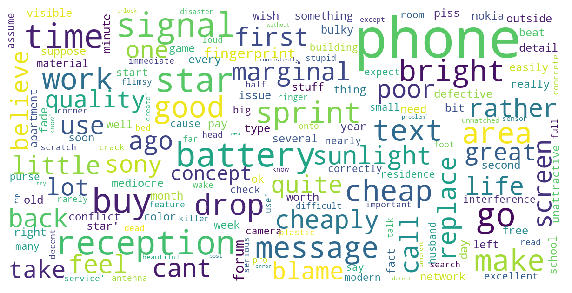

In [39]:
# print wordcloud of most negative reviews
amazon_neg_reviews = amazon_reviews[amazon_reviews["totalScore"] <= -0.5]
show_wordcloud(amazon_neg_reviews["reviewClean"].values)

We can see some words that could tell us some negative products (phones) issues: signal, battery, reception, screen. 

In [40]:
# highest positive sentiment reviews (with more than 5 words)
amazon_reviews[amazon_reviews["nWords"] >= 5].sort_values("positiveScore", ascending = False)[["asin","reviewComplete", "positiveScore"]].head(10)

,asin,reviewComplete,positiveScore
47599,B07CHWMYHP,Excellent!! Super Cool Excellent!! Thank you!!,1.000
4382,B00A2V7BA4,LOVE IT! LOVE IT!! LOVE IT!! LOVE IT!! LOVE IT...,1.000
38773,B07536MYBQ,The best! Love love love it! Thank you Amazon,1.000
34379,B06Y16RL4W,"Definitely satisfied Love, love, love it!",1.000
56956,B07N91S9MW,Great value Definitely a great value,1.000
23419,B01FCFZS3G,"I love Amazon This was a gift for a friend, th...",0.949
18234,B014GCG150,"It was a gift for a coworker, he loves ... It ...",0.948
63550,B07RWFC6NY,Love love love Love this phone,0.944
10066,B00HPP3QD6,wonderful Value I love my moto g feel it was a...,0.943
21824,B01D1J9BGU,Awesome. Love it. Definitely recommended. Good...,0.943


The most positive reviews correspond to good feedbacks.

In [41]:
# lowest negative sentiment reviews (with more than 5 words)
amazon_reviews[amazon_reviews["nWords"] >= 5].sort_values("negativeScore", ascending = False)[["asin","reviewComplete", "negativeScore"]].head(10)

,asin,reviewComplete,negativeScore
33638,B06Y14K2C6,Blah blah blah blah blah blah Blah blah blah b...,1.000
39983,B075ZD2WFN,Bad bad Bad bad bad,1.000
61375,B07Q84DPZH,Terrible disappointment Worst phone ever.,0.832
48796,B07D6TQP6F,it was just every thing was bad and it sucked ...,0.832
41993,B0775451TT,it was just every thing was bad and it sucked ...,0.832
22362,B01D1J9BGU,"on time, no problem. on time ,no problem .",0.831
25147,B01JAWWVXW,No problem with phone No problem with phone,0.831
31728,B06XRJQX91,Fake iPhone Fake phone All products are fake,0.823
10966,B00JYR6GGM,stolen The phone I received was stolen and is ...,0.821
53533,B07HKQJ6H1,Severe screen damage Poor condition,0.817


We can see some errors on the most negative reviews (Eg. "No problem with phone No problem with phone"). The Vader sentiment analysis algorithm sometimes interpret 'no' as negative words whereas they are sometimes used to say that there were no problems. However, we can see how most of the reviews are bad ones.

The following graph shows the distribution of the reviews sentiments (positive and negative) among products returned and the ones that were not returned.

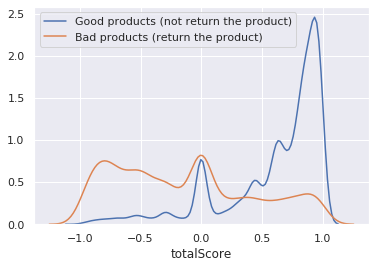

In [42]:
# plot sentiment distribution for positive and negative reviews with the class variable return product
for x in [0, 1]:
    subset = amazon_reviews[amazon_reviews['returnProduct'] == x]
    # Draw the density plot
    if x == 0:
        label = "Good products (not return the product)"
    else:
        label = "Bad products (return the product)"
#     plt.legend()
    sns.distplot(subset['totalScore'], label= label, hist = False)

We can see that not returned products are for most of them considered as very positive by Vader. On the contrary, the products returned tend to have lower compound sentiment scores.

## Predicting whether the customer will return the product or not 

To predict whether the customer will return the product or not, we will combine both datasets to get all the information related to products and reviews. We will predict using the following selection feature strategies:
- Predicting returned product using the best importance features obtained by RandomForest
- Predicting returned product using only the features obtained by the information extracted from the text review.
- Predicting returned product using the best-performing features obtained by the RFECV selection algorithm.

We're going to work with four algorithms: logistic regression, a deep learning neuronal network designed using Keras, random forests and XGBoost, an implementation of gradient boosted decision trees. Most of the algorithms selected make predictions using different methods. We tune the algorithms to improve their performance on imbalanced datasets.

We train a number of models across a 'grid' of values and then searched for the model that gave us the highest AUC (Area under the ROC curve). We use model_selection.GridSearchCV() from Scikit-learn.

Let's combine both datasets

In [43]:
df_review_products = amazon_reviews.merge(amazon_products, on="asin", how="left")

# rename columns once both dataframe were combined
df_review_products.rename(columns={"rating_x": "ratingProductReview", "rating_y": "avgRating"}, inplace=True)

# drop asin, reviewComplete and reviewClean from df_review_products
df_review_products = df_review_products.drop(['asin', 'reviewComplete', 'reviewClean'], axis=1)
df_review_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67033 entries, 0 to 67032
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ratingProductReview  67033 non-null  float64
 1   returnProduct        67033 non-null  int64  
 2   nChars               67033 non-null  int64  
 3   nWords               67033 non-null  int64  
 4   negativeScore        67033 non-null  float64
 5   neutralScore         67033 non-null  float64
 6   positiveScore        67033 non-null  float64
 7   totalScore           67033 non-null  float64
 8   doc2vec_vector_0     67033 non-null  float32
 9   doc2vec_vector_1     67033 non-null  float32
 10  doc2vec_vector_2     67033 non-null  float32
 11  doc2vec_vector_3     67033 non-null  float32
 12  doc2vec_vector_4     67033 non-null  float32
 13  word_but             67033 non-null  float64
 14  word_great           67033 non-null  float64
 15  word_not             67033 non-null 

Since, we are adding more features, the collinearity between them need to be checked. Collinearity occurs where more than one feature contains data that are similar. A common way to spot collinearity is to plot correlations between each pair of variables in a heatmap.


In [44]:
# A function that make it easier to plot the correlations between the features in our data.
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(20, 13))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()


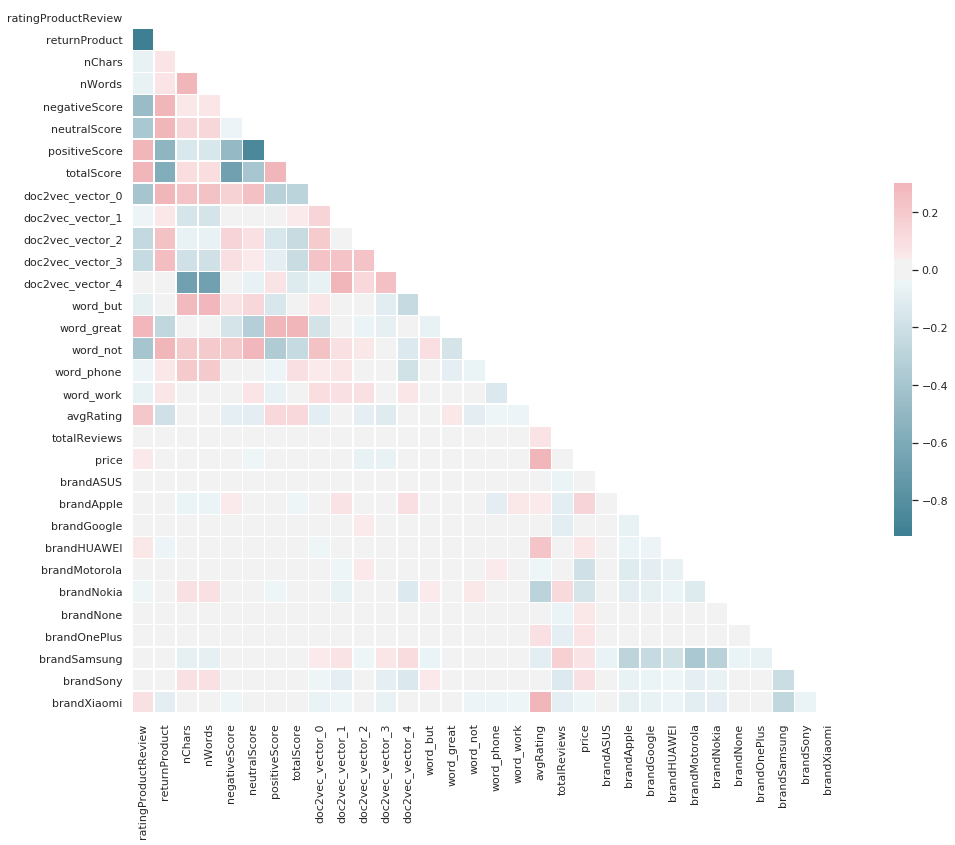

In [45]:
selected_columns = df_review_products.columns.tolist()
# selected_columns.remove('returnProduct')
plot_correlation_heatmap(df_review_products)

In general, as we expected there is a negative correlation between returnProduct and ratingProductReview. In addition, there also a negative correlation between positive_score and neutral_score.

Let's split into train/test sets our dataframe. Notice that the stratify parameter used allows us to preserve the same proportions of examples in each class as observed in our original dataset.

In [46]:
# split into train/test sets
features = df_review_products.columns.tolist()
label = "returnProduct"
features.remove(label)
train_x, test_x, train_y, test_y = train_test_split(df_review_products[features], df_review_products[label], random_state=0, stratify=df_review_products[label], shuffle=True)

### Predicting returned product using the best importance features obtained by RandomForest

- Select the features using the best ones obtained by random forest

In [47]:
# train a random forest classifier using all features
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(train_x, train_y)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(10)

,feature,importance
0,ratingProductReview,0.640557
6,totalScore,0.080991
5,positiveScore,0.076229
3,negativeScore,0.031144
7,doc2vec_vector_0,0.029968
14,word_not,0.023006
10,doc2vec_vector_3,0.021401
4,neutralScore,0.020177
9,doc2vec_vector_2,0.011130
1,nChars,0.009344


The most important feature is ratingProduct. Moreover, the features that come from the previous sentiment analysis are also listed as the important ones. The vector representations of the texts also have importance in our training. The word 'not' appears to have a quite good importance as well.

Let's select the best 7 features to make predictions on our class feature.

In [48]:
best_feature_rf = feature_importances_df.iloc[:7,0]
train_x_rf_features = train_x[best_feature_rf]
test_x_rf_features = test_x[best_feature_rf]

In [49]:
train_x_rf_features.head()

,ratingProductReview,totalScore,positiveScore,negativeScore,doc2vec_vector_0,word_not,doc2vec_vector_3
44117,1.00,0.6369,0.808,0.000,0.040157,0.000000,-0.046910
58723,1.00,0.9231,0.429,0.097,-0.348719,0.000000,0.039745
23669,0.50,-0.5423,0.000,0.538,0.075024,0.000000,-0.001372
46821,0.50,-0.4404,0.000,0.420,-0.038774,0.000000,-0.050150
6137,0.25,-0.9290,0.088,0.266,-0.127004,0.430428,-0.086994


- Model Selection and Tuning using best importance features by RandomForest <a class="anchor" id="model-selection"></a>

First, we will create a deep neuronal network model using keras.

In [66]:
# define deep neuronal network model with keras
def create_NN_model(learn_rate=0.01, input_dim=None):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim, kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt_adam = tf.keras.optimizers.Adam(learning_rate=learn_rate)
    model.compile(optimizer = "adam", loss='binary_crossentropy', metrics=[keras.metrics.AUC()])
    return model

Let' calculate the weighting to use for each class by calling the compute_class_weight() function and specifying the class_weight as “balanced.”

In [67]:
#to calculate the class weight 
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.67202245689079, 1: 1.953298624601756}


A method to select the best model with the best parameters.

In [70]:
# select the best classification model
def select_model(trainX,trainy):
    input_dim = trainX.shape[1]
    
    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["lbfgs", "liblinear"],
                    "class_weight": [{0: 0.672, 1: 1.95}]
                }
        },
        {
            "name": "KerasClassifier",
            "estimator": KerasClassifier(build_fn=create_NN_model, verbose=0, input_dim = input_dim),
            "hyperparameters":
                {
                    "batch_size": [20],  
                    "learn_rate": [0.01, 0.1],
                    "epochs": [15, 30],
                }
        },
        {
            "name": "XGBClassifier",
            "estimator": XGBClassifier(),
            "hyperparameters":
                {
                    'n_estimators': [100],
                    'max_depth': [3, 6],
                    'learning_rate': [0.01, 0.1, 0.2], 
                    'objective': ['binary:logistic'],
                    'eval_metric': ["auc"],
                    'seed': [42],
                    'scale_pos_weight': [2.9], # around 2.9 in our problem (sum(negative instances) / sum(positive instances))
                    'use_label_encoder':[False]

                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1), #Weighted Random Forest
            "hyperparameters":
                {
                    "n_estimators": [100],
                    "criterion": ["entropy","gini"],
                    "max_features": ["log2", "sqrt"],
                    'max_depth': [3, 6],
                    'class_weight': ['balanced_subsample'] #change the class weighting based on the class distribution in each bootstrap sample

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))
        # define evaluation procedure
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=cv, n_jobs=-1, scoring = 'roc_auc', return_train_score=True)
        if model['name'] == "KerasClassifier":
            history = grid.fit(trainX,trainy, class_weight={0: 0.67, 1: 1.95})
        else:   
            history = grid.fit(trainX,trainy)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        model["cv_results"] = grid.cv_results_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models


Let's select the best model for this dataset

In [71]:
result_models = select_model(train_x_rf_features,train_y)

LogisticRegression
------------------
Best Score: 0.9991599273943201
Best Parameters: {'class_weight': {0: 0.672, 1: 1.95}, 'solver': 'liblinear'}

KerasClassifier
---------------
Best Score: 0.9994676109768557
Best Parameters: {'batch_size': 20, 'epochs': 30, 'learn_rate': 0.1}

XGBClassifier
-------------
Best Score: 0.9994834864948284
Best Parameters: {'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 2.9, 'seed': 42, 'use_label_encoder': False}

RandomForestClassifier
----------------------
Best Score: 0.9992050773512637
Best Parameters: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 100}



- Predict holdout data (test dataset) using the best model

In [72]:
# a method to predict the holdout data and show classification metrics
# parameters: the results of the models obtained by GridSearchCV, test_x and test_y data
def predict_holdout_data(result_models, test_x, test_y):
    
    # sort the results_model list to select the model with the highest score
    result_models_sorted = sorted(result_models, key=lambda k: k['best_score'], reverse=True)
    model = result_models_sorted[0]["best_model"]
    print("Best Model: {}".format(result_models_sorted[0]["name"]))
    
    # making predictios on test data
    y_pred = model.predict(test_x)
    y_pred_prob = [x[1] for x in model.predict_proba(test_x)]
    
    # show classification metrics to evaluate the performance of the model
    fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    print("AUC Score:", roc_auc)
    print('Precision Score : ' + str(precision_score(test_y,y_pred)))
    print('Recall Score : ' + str(recall_score(test_y,y_pred)))
    print('F1 Score : ' + str(f1_score(test_y,y_pred)))
    print('Accuracy Score : ' + str(accuracy_score(test_y,y_pred)))
    
    #plot roc curve
    plt.figure(1, figsize = (4, 4))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    #plot confusion matrix
    cm = confusion_matrix(test_y,y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

Best Model: XGBClassifier
AUC Score: 0.9993863008699803
Precision Score : 0.9830747531734838
Recall Score : 0.9748251748251748
F1 Score : 0.978932584269663
Accuracy Score : 0.9892595023569425


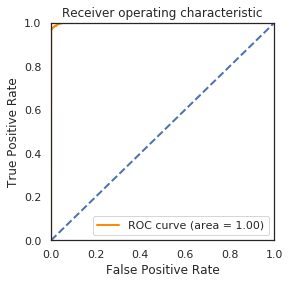

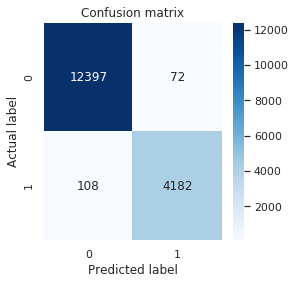

In [73]:
# predict the holdout data using the best importance feautures from random forest and the best machine learning model trained
predict_holdout_data(result_models, test_x_rf_features, test_y)

The classification algorithms obtain high values of the quality metrics, where the one with best performance is XGBoost. Notice that the number of missclassified examples are very low, which could be because the use of the rating feature who is high correlated with the returnProduct attribute.

### Predicting returned product using only the raw textual data from the review

Let's use only the features obtained by the information extracted from the text review.

In [74]:
ignore_cols = ['ratingProductReview', 'avgRating', 'totalReviews', 'price', 'brandASUS', 'brandApple', 'brandGoogle', 'brandHUAWEI', 'brandMotorola',
       'brandNokia', 'brandNone', 'brandOnePlus', 'brandSamsung', 'brandSony', 'brandXiaomi']
features = [c for c in train_x.columns if c not in ignore_cols]
train_x_text_review_features = train_x[features]
test_x_text_review_features = test_x[features]

In [75]:
train_x_text_review_features.head()

,nChars,nWords,negativeScore,neutralScore,positiveScore,totalScore,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,word_but,word_great,word_not,word_phone,word_work
44117,8,2,0.000,0.192,0.808,0.6369,0.040157,0.119785,0.038873,-0.046910,-0.156309,0.000000,0.000000,0.000000,0.000000,0.000000
58723,154,25,0.097,0.474,0.429,0.9231,-0.348719,0.081799,0.248024,0.039745,0.081565,0.000000,0.618717,0.000000,0.785614,0.000000
23669,24,4,0.538,0.462,0.000,-0.5423,0.075024,0.073734,0.118005,-0.001372,0.061828,0.000000,0.000000,0.000000,0.000000,0.000000
46821,30,5,0.420,0.580,0.000,-0.4404,-0.038774,0.254306,0.175731,-0.050150,-0.189075,0.000000,0.000000,0.000000,0.000000,0.000000
6137,364,60,0.266,0.646,0.088,-0.9290,-0.127004,-0.088914,0.841703,-0.086994,-0.395043,0.221419,0.000000,0.430428,0.550638,0.680075


- Model Selection and Tuning using only the features obtained from the text review

In [76]:
results_models_feature_text = select_model(train_x_text_review_features,train_y)

LogisticRegression
------------------
Best Score: 0.9215879819306882
Best Parameters: {'class_weight': {0: 0.672, 1: 1.95}, 'solver': 'liblinear'}

KerasClassifier
---------------
Best Score: 0.9275502379065633
Best Parameters: {'batch_size': 20, 'epochs': 30, 'learn_rate': 0.01}

XGBClassifier
-------------
Best Score: 0.9315943300925025
Best Parameters: {'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 2.9, 'seed': 42, 'use_label_encoder': False}

RandomForestClassifier
----------------------
Best Score: 0.9240285921551162
Best Parameters: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 100}



- Predict the holdout data using only the features obtained from the text review

Best Model: XGBClassifier
AUC Score: 0.9328534579276418
Precision Score : 0.6700035752592063
Recall Score : 0.8736596736596737
F1 Score : 0.7583974099554837
Accuracy Score : 0.8575093979354377


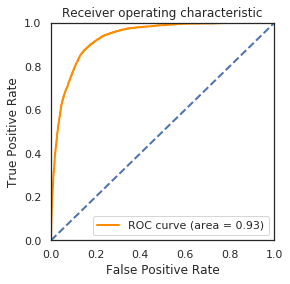

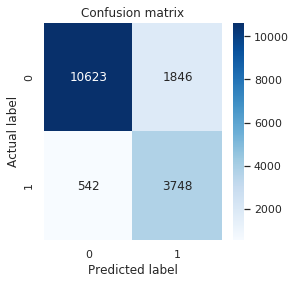

In [77]:
# predict the holdout data using only the features obtained from the text review and the best machine learning model trained
predict_holdout_data(results_models_feature_text, test_x_text_review_features, test_y)

The best performance algorithm is also XGBoost. The results shows how the algorithm present less precision since the model makes more mistakes to predict when the product will be returned.

### Predicting returned product using the best-performing features obtained by the RFECV selection algorithm

We will use the logit coefficients to select the most relevant features, using the feature_selection.RFECV class, which performs recursive feature elimination with cross-validation. The RFECV class starts by training a model using all of the features and scores it using cross validation. It then uses the logit coefficients to eliminate the least important feature, and trains and scores a new model. At the end, the class looks at all the scores, and selects the set of features which scored highest.

In [95]:
# select random forest as the estimator that will be used by RFECV 
features = df_review_products.columns.tolist()
features.remove(label)
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
selector = RFECV(rf,cv=10)
selector.fit(df_review_products[features], df_review_products[label])

RFECV(cv=10,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [97]:
best_columns_RFECV = list(df_review_products[features].columns[selector.support_])
print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns_RFECV))
print("Number of new features", len(best_columns_RFECV))

Best Columns 
------------
['ratingProductReview', 'nChars', 'nWords', 'negativeScore', 'neutralScore', 'positiveScore', 'totalScore', 'doc2vec_vector_0', 'doc2vec_vector_1', 'doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4', 'word_but', 'word_great', 'word_not', 'word_phone', 'word_work', 'avgRating', 'totalReviews', 'price', 'brandGoogle', 'brandMotorola', 'brandNokia', 'brandSamsung', 'brandXiaomi']

Number of new features 25


In [98]:
# select the best features obtained by the RFECV feature selection algorithm
train_x_best_features_RFECV = train_x[best_columns_RFECV]
test_x_best_features_RFECV = test_x[best_columns_RFECV]

- Model Selection and Tuning using the features obtained by the RFECV selection algorithm ¶

In [100]:
results_models_feature_RFECV = select_model(train_x_best_features_RFECV,train_y)

LogisticRegression
------------------
Best Score: 0.9995193315683786
Best Parameters: {'class_weight': {0: 0.672, 1: 1.95}, 'solver': 'liblinear'}

KerasClassifier
---------------
Best Score: 0.9994745516680681
Best Parameters: {'batch_size': 20, 'epochs': 30, 'learn_rate': 0.1}

XGBClassifier
-------------
Best Score: 0.9996274655586965
Best Parameters: {'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 2.9, 'seed': 42, 'use_label_encoder': False}

RandomForestClassifier
----------------------
Best Score: 0.9984574178259875
Best Parameters: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 100}



- Predicting the holdout data 

Best Model: XGBClassifier
AUC Score: 0.9996145031753341
Precision Score : 0.9843457943925233
Recall Score : 0.982051282051282
F1 Score : 0.9831971995332556
Accuracy Score : 0.991407601885554


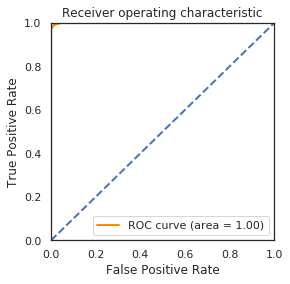

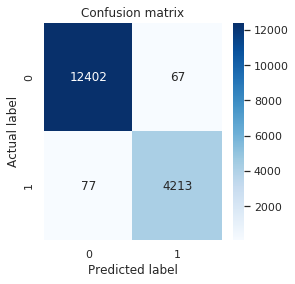

In [101]:
# predict the holdout data
predict_holdout_data(results_models_feature_RFECV, test_x_best_features_RFECV, test_y)

The classification algorithms obtain high values of the quality metrics, where also the one with best performance is XGBoost.

## Identify whether there is any item on their stock that customer find disappointing

We want to identify for each item in their stock if the customer would find disappointing. We could guess that when the customer is happy corresponds to a positive review with high rating of the product and the product is not returned. On the other hand, when the customer is not satisfied corresponds to a negative review with low rating and the product is returned.

In order to simplify the problem we will split into two categories the features rating and total_score that represent sentiment analysis on the text review, as follows:

- positive rating for values higher than 0.5 (customer give a rating higher than 3), otherwise the rating is negative.
- positive reviews for values of total_score higher or equal to 0.5 and the ones less than -0.5 are negative.  

Then, we design a dissapointed score for each product based on the probability that the product could be returned, the customer give a negative review and a negative rating. Moreover, we weight this probailites in order to give more importance when the product is returned. The dissapointed score for each product is defined as follows:

\begin{equation}
dissapointed\_score(p)= w_{return}*P(p_{return})+ w_{review}*P(p_{neg\_review})+ w_{rating}*P(p_{neg\_rating})
\end{equation}

The weight's values used are $w_{return}=0.45$ , $w_{rating}=0.35$ and $w_{review}=0.2$.

The domain of the dissapointed score is [0, 1], where values close to 1 represent the most dissapointed level.

Notice that a user could define new weight's values to decide how to balance the importance of the probabilities used.

Then, we define that a product could be dissapointed if the dessapointed score is higher than 0.5. This value also can be changed by the users.

Let's discretize the rating and total_score features.

In [102]:
# if the rating is higher than 0.5 (customer give a rating higher than 3) the rating is considered positive, otherwise it is negative
def rating_categ(rating):
    if rating > 0.5:
        return 'pos'
    else:
        return 'neg'

In [103]:
# VADER sentiment analysis tool for getting pos, neg and neu.
def sentimental_categ(score):
    if score >= 0.5:
        return 'pos'
    elif (score > -0.5) and (score < 0.5):
        return 'neu'
    elif score <= -0.5:
        return 'neg'

Adding the total score and rating categorized as new columns in amazon_review

In [104]:
amazon_reviews['sentiment_categ']=amazon_reviews['totalScore'].apply(lambda x: sentimental_categ(x))    
# create dissapointed score column for each review
amazon_reviews['rating_categ'] = amazon_reviews['rating'].apply(lambda x: rating_categ(x))

Let's plot the distribution of the features that will be used in the dissapointed score

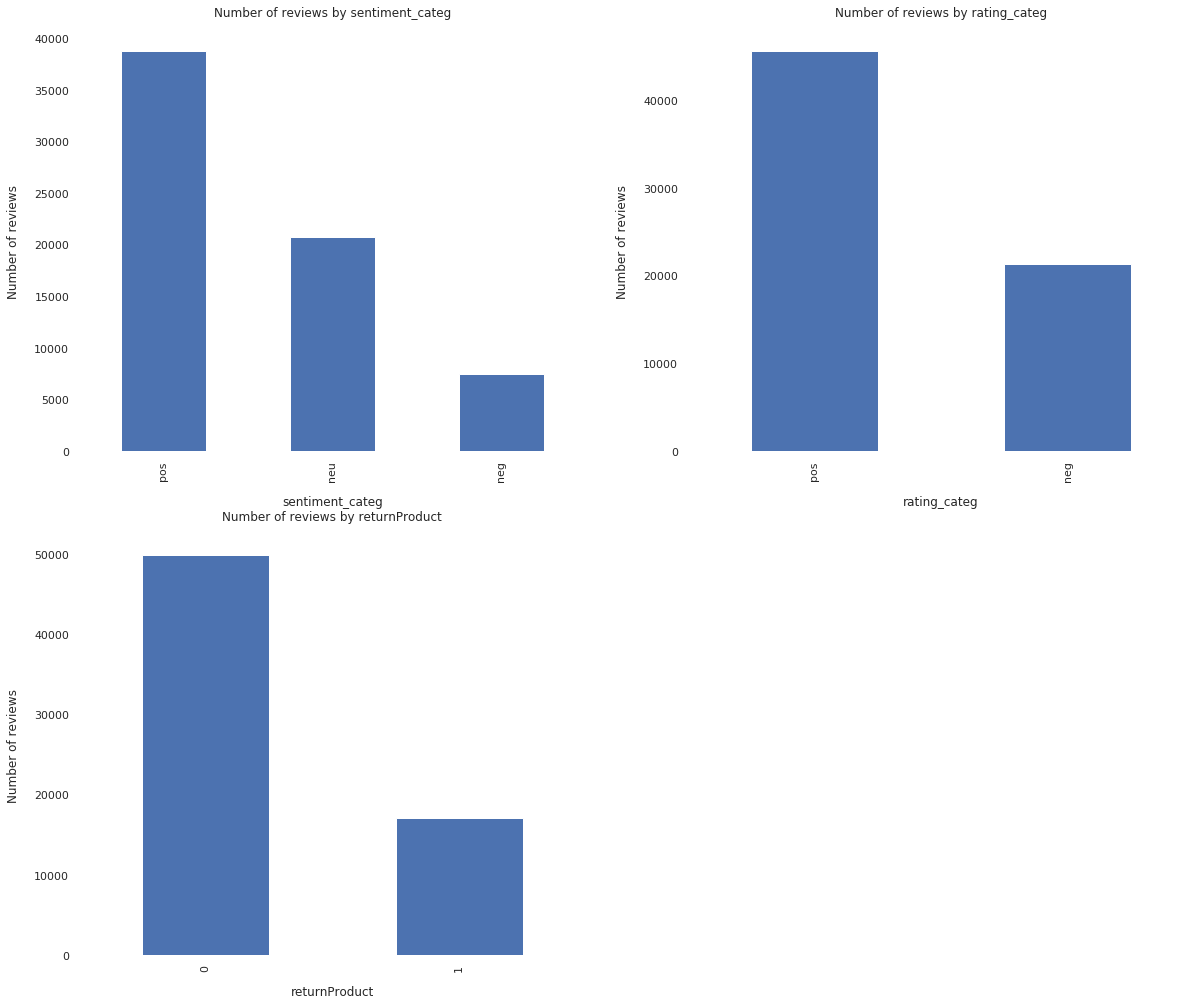

In [122]:
fig = plt.figure(figsize=(20, 17))
categ_cols = ["sentiment_categ", "rating_categ", "returnProduct"]
for i, col_name in zip(range(len(categ_cols)), categ_cols):
    ax = fig.add_subplot(2,2,i+1)
    ax = amazon_reviews[col_name].value_counts().plot(kind='bar')
    ax.set_ylabel("Number of reviews", labelpad=14)
    ax.set_title("Number of reviews by " + col_name, y=1.02);
        
    for key,spine in ax.spines.items():
         spine.set_visible(False)
    ax.set_xlabel(col_name, labelpad=14)

As we expected, most of the customer give positive reviews, with positive ratings and keep the products.

Calculating the dissapointed score for each product

In [106]:
# function to get dissapointed score for each product based on probability that the product could be returned, the customer give a negative review and negarive rating
def dissapointed_score(df_product):
    d = {}
    d['prob_return'] = df_product[df_product['returnProduct'] == 1].shape[0]/len(df_product)
    d['prob_sentim_neg'] = df_product[df_product['sentiment_categ'] == 'neg'].shape[0]/len(df_product)
    d['prob_rating_neg'] = df_product[df_product['rating_categ'] == 'neg'].shape[0]/len(df_product)
    d['dissapointed_score'] =  0.45*d['prob_return'] + 0.2*d['prob_sentim_neg'] + 0.35*d['prob_rating_neg']
    return pd.Series(d, index=['prob_return', 'prob_sentim_neg', 'prob_rating_neg', 'dissapointed_score'])

In [110]:
df = amazon_reviews.groupby('asin', as_index=True).apply(dissapointed_score)

In [111]:
df.head()

,prob_return,prob_sentim_neg,prob_rating_neg,dissapointed_score
asin,,,,
B0000SX2UC,0.285714,0.142857,0.428571,0.307143
B0009N5L7K,0.500000,0.166667,0.500000,0.433333
B000SKTZ0S,0.227273,0.045455,0.318182,0.222727
B001AO4OUC,0.400000,0.350000,0.400000,0.390000
B001DCJAJG,0.166667,0.083333,0.416667,0.237500


Merging the probabilities and dissapointed score obtained for each product to amazon_products dataset.

In [113]:
df_products_dissp = amazon_products.merge(df, on="asin", how="left")
df_products_dissp.head()

,asin,rating,totalReviews,price,brandASUS,brandApple,brandGoogle,brandHUAWEI,brandMotorola,brandNokia,brandNone,brandOnePlus,brandSamsung,brandSony,brandXiaomi,prob_return,prob_sentim_neg,prob_rating_neg,dissapointed_score
0,B0000SX2UC,0.500,0.013238,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.285714,0.142857,0.428571,0.307143
1,B0009N5L7K,0.500,0.006110,0.049950,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.166667,0.500000,0.433333
2,B000SKTZ0S,0.425,0.021385,0.099991,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227273,0.045455,0.318182,0.222727
3,B001AO4OUC,0.575,0.020367,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,0.350000,0.400000,0.390000
4,B001DCJAJG,0.525,0.011202,0.149991,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.083333,0.416667,0.237500


Let's calculate the number of products without dissapointed score, since if the product didnt present cutomer's reviews the dissapointed score will be empty.

In [114]:
print("Number of products without dissapointed_score: {}".format(df_products_dissp['dissapointed_score'].isnull().sum()))

Number of products without dissapointed_score: 1


In [115]:
#fill with median the missing values of dissapointed score for each product
df_products_dissp['dissapointed_score'].fillna(df_products_dissp['dissapointed_score'].median(), inplace=True)

Let's plot the distribution of the dissapointed score.

Text(0.5, 1.02, 'Distribution of dissapointed score from products')

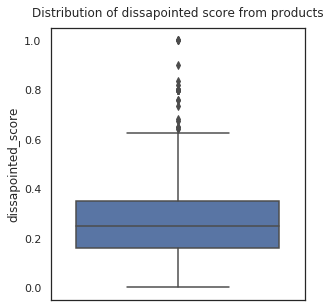

In [116]:
# plotting the distribution of dissapointed score using boxplot charts
fig = plt.figure(figsize=(10,5))
#create two charts for each rating column in both datasets
# ax = fig.add_subplot(1,2,1)
# ax = sns.boxplot(y=amazon_reviews['dissap_score'])
# ax.set_title("Distribution of dissaponted score from reviews", y=1.02)
   
ax = fig.add_subplot(1,2,2)
ax = sns.boxplot(y=df_products_dissp['dissapointed_score'])
ax.set_title("Distribution of dissapointed score from products", y=1.02)
   

We can see how most of the products present low dissapointed score less than 0.4, which is that we expected since most of them present positive comments from the customers. Notice how some product present the highest dissapointed score, which represent the ones that were returned with high probability and receive negative ratings and reviews from customers.

Creating a column to identify a possible dissapointed product 

In [117]:
# create a column to identify a possible dissapointed product
def dissapointed_product(dissap_score):
    if dissap_score < 0.5:
        return 0 # product could satisfy a customer
    elif dissap_score >= 0.5:
        return 1 # product could be dissapointed
# create dissapointed column for each product
df_products_dissp['dissapointed_product'] = df_products_dissp['dissapointed_score'].apply(lambda score: dissapointed_product(score))

Plotting the distribution of the dissapointed products in the dataset

0    0.905556
1    0.094444
Name: dissapointed_product, dtype: float64

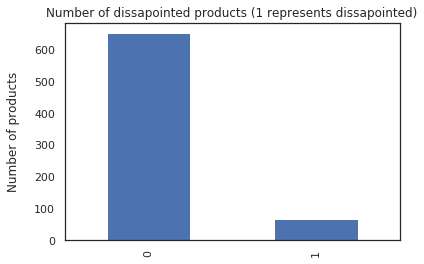

In [118]:
ax = df_products_dissp['dissapointed_product'].value_counts().plot(kind='bar')
ax.set_ylabel("Number of products", labelpad=14)
ax.set_title("Number of dissapointed products (1 represents dissapointed)");
df_products_dissp['dissapointed_product'].value_counts(normalize = True)

We can see how only 0.09% of the products are dissapointed, then most of products could make happy the customers.

## Conclusions

In this project, we predict whether the customer will return the product or not based on the customer review. Moreover, we identify whether there is any item on their stock that customer find disappointing. The conclusions we reached are the following:
- Extract relevant features (sentiment analysis features, word embeddings, etc) from the text reviews are very important to be able to predict a returned product.
- The sentiment analysis done allow us to identify the positive and negative customer's reviews.
- XGBoost is the best performing method when compared with the other algorithms used in this study.
- As we expect, the quality of the results obtained when is used only raw text as input for making predictions is less than the others analysis when the other features are used. However, notice that is completely possible to do it with quite good predictions.
- The dissapointed score measure allow us to identify a possible dissapointed product.

## Future works

The following ideas could improve the results obtained:

- Few customer's reviews are in spanish, then, we could detect the language in order to clean the text associate wih the language corresponed, as stop words, words from vocabulary, etc.
- When we remove the unusal words from english, some misspelling words would be removed. We could do some actions to correct the spelling.
- Evaluate the results of the sentimental analysis algorithms where without remove the stop words.
- Analyse the relation between the customer that are not verified and the negative reviews and ratings.
- Design an approach where the date of the review could make some impact in the dissapointed score, since old negative reviews could have less impact than the new ones.
- There are different researches related to identify the emotions that the emojis could express. Analyse some of them could be an idea to improve the information extracted from the data.
- Tune different parameters at the feature engineering process when the review text is analysed, as: the size of the vector in the Word2Vec algorithm, the number of TF-IDF columns that could be added.
- Tune threshold values to categorize sentiment score of the reviews, ratings and dissapointed score.
- Improve code efficiency in order to use less .apply methods, adding python pipelines, etc.